# SUPERVISED LEARNING

# Gradient Boosting 
## Decision Trees
## Mean Square Error
## _by hand_

We will need:
- sklearn
- matplotlib
- numpy
- xgboost

We will use _boston dataset_ from sklearn.datasets library which has information related to home prices in Boston.

### Data Load

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import model_selection, tree, metrics, ensemble

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)
print(boston.keys())
print(boston.DESCR)

(506, 13)
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
   

In [4]:
X = boston.data
X.shape
y = boston.target
y.shape

(506,)

In [5]:
# 75% train, 25% test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 1)

**Boosting** is a method of compositions constructed on basic algorithms by successively adding a new algorithm to the current composition with a certain coefficient.

Gradient Boosting trains each new algorithm so that it approximates the anti-gradient error by composition responses on the training set. Similar to minimizing functions using the gradient descent method, in gradient boosting we correct composition, changing the algorithm towards antigradient error.

Using the formula that defines the answers on the training sample for which we need to train the new algorithm (in fact, this is just a slightly more detailed gradient from the error), we can get its special case if the loss function _L_ is the  squared response deviation of the composition _a(x)_ from the correct answer _y_:

Loss function:   $$L(a(x)) = (a(x)-y)^2$$

Displacement:  $$L'(a(x)) = 2(a(x) - y)$$

The coefficient = _2_ could be ignored, because we still have to choose a coefficient with which a new basic algorithm will be added.

### 1. Learning algorithm building

Let's get arrays for _DecisionTreeRegressor_ objects (we will use them as basic algorithms) and for real numbers (these will be the coefficients before the basic algorithms).

Then, we train 50 decision trees in sequence with _max_depth = 5_. In Boosting it is often used hundreds and thousands of trees, but we are limited to 50, so the algorithm can work faster, and makes it easier to debug. Each tree must be trained on the same set of objects, but the answers that the tree learns to predict will change in accordance with the rule obtained in the formula before.

Let's start from coefficient equal to 0.9 always. It is usually justified to choose a coefficient much smaller - of the order of 0.05 or 0.1, but since in our case study there will be only 50 trees, for a start we take a larger step.

During the learning, we will need a function that will calculate the forecast of the currently constructed composition of trees on the sample _X_ (it will work both for train and test samples):

In [6]:
def gbm_predict(X):
    return [sum([coeff * algoritm.predict([x])[0] for algoritm, coeff in zip(base_algor_list, coef_list)]) for x in X]

In [7]:
# Learning

base_algor_list = []
coef_list = []
dsp = y_train     # displacement
N = 50     # number od trees

import timeit
start = timeit.default_timer()

for i in range(0, N):
    regressor = tree.DecisionTreeRegressor(max_depth = 5, random_state = 42)
    regressor.fit(X_train, dsp)
    coef_list.append(0.9)
    base_algor_list.append(regressor)
    dsp = y_train - gbm_predict(X_train)     # y - displacement
    
print('Time: ', timeit.default_timer() - start)

Time:  30.580412455999976


In [8]:
# Test

y_pred = gbm_predict(X_test)
print('RSME: ', (metrics.mean_squared_error(y_test, y_pred))**0.5)

RSME:  3.8430045851125367


### 2.  Algorithm improvement

We may also be concerned that moving with a constant step, near the minimum of the error, the answers on the training set change too sharply, jumping over the minimum. Therefore, we can reduce the weight of each algorithm before each following iteration by using the next proportion:

$$0.9 / (1.0 + i)$$
where _i_ - current iteration number

In [9]:
# Learning

base_algorithms_list = []
coef_list = []
dsp = y_train
N = 50

import timeit
start = timeit.default_timer()

for i in range(0, N):
    regressor = tree.DecisionTreeRegressor(max_depth = 5, random_state = 42)
    regressor.fit(X_train, dsp)
    coef_list.append(0.9/(1+i))
    base_algor_list.append(regressor)
    dsp = y_train - gbm_predict(X_train)    
    
print('Time: ', timeit.default_timer() - start)

Time:  33.26968969599989


In [10]:
# Test

y_pred = gbm_predict(X_test)
print('RSME: ', (metrics.mean_squared_error(y_test, y_pred))**0.5)

RSME:  3.397676017995277


### 3. XGBoost

Gradient Boosting method is very popular method in Machine Learning. Let's use one that is presented in a third-party library: _XGBoost_. Also, we could use _GradientBoostingRegressor_ from sklearn, but in practice, _XGBoost_ works noticeably better.

Let's perform the _XGBoost_ method and observe, whether Gradient Boosting is overfitting with the increase of numbers of iterations (number of trees), as well as with increase of the depth of trees.

In [12]:
import xgboost as xgb
import numpy as np

### n_trees

In [13]:
n_trees = np.arange(10, 150, 10)
xgb_scoring = np.zeros(n_trees.shape[0])
xgb_scoring_train = np.zeros(n_trees.shape[0])

xgb_scoring.shape

(14,)

In [14]:
%%time
i = 0
for n in n_trees:
    xgb_R = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=n, verbosity=0)
    xgb_R.fit(X_train, y_train)
    y_pred_train = xgb_R.predict(X_train)
    y_pred = xgb_R.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    xgb_scoring[i] = mse
    mse_train = metrics.mean_squared_error(y_train, y_pred_train)
    xgb_scoring_train[i] = mse_train
    i = i+1 

CPU times: user 715 ms, sys: 5 ms, total: 720 ms
Wall time: 726 ms


In [15]:
#print(sorted(metrics.SCORERS.keys()))

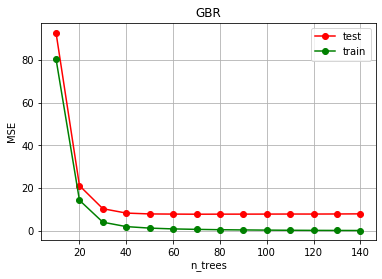

In [16]:
pylab.grid(True)
pylab.plot(n_trees, xgb_scoring, 'r-', marker='o', label='test')
pylab.plot(n_trees, xgb_scoring_train, 'g-', marker='o', label='train')
pylab.title('GBR')
pylab.xlabel('n_trees')
pylab.ylabel('MSE')
pylab.legend(loc='upper right')

As we increase the number of trees, it gets to a point where the quality of Gradient Boosting does not change significantly.

### n_depth

In [17]:
n_depth = np.arange(2, 17, 2)  
xgb_scoring = np.zeros(n_depth.shape[0])
xgb_scoring_train = np.zeros(n_depth.shape[0])
xgb_scoring.shape
n_depth

array([ 2,  4,  6,  8, 10, 12, 14, 16])

In [18]:
%%time
i = 0
for n in n_depth:
    xgb_R = xgb.XGBRegressor(learning_rate=0.1, max_depth=n, n_estimators=100, verbosity=0)
    xgb_R.fit(X_train, y_train)
    y_pred_train = xgb_R.predict(X_train)
    y_pred = xgb_R.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    xgb_scoring[i] = mse
    mse_train = metrics.mean_squared_error(y_train, y_pred_train)
    xgb_scoring_train[i] = mse_train
    i = i+1 

CPU times: user 847 ms, sys: 5 ms, total: 852 ms
Wall time: 855 ms


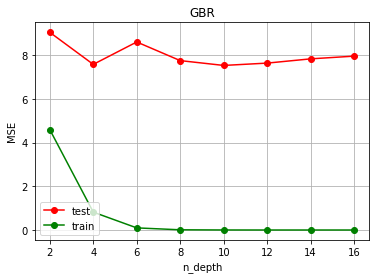

In [19]:
pylab.grid(True)
pylab.plot(n_depth, xgb_scoring, 'r-', marker='o', label='test')
pylab.plot(n_depth, xgb_scoring_train, 'g-', marker='o', label='train')
pylab.title('GBR')
pylab.xlabel('n_depth')
pylab.ylabel('MSE')
pylab.legend(loc='lower left')

In the same manner, as we increase the number of depths of trees, it also gets to a point where the quality of Gradient Boosting on a test sample begins to deteriorate (the optimum depth for this dataset is about 4...8).

### 4. Gradient Boosting Vs Lineal Regression

It will be interesting to compare the results of Gradient Boosting method with other classificator. 

In [20]:
xgb_R = xgb.XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=100, verbosity=0)
xgb_R.fit(X_train, y_train)
y_pred = xgb_R.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print('RSME: ', (metrics.mean_squared_error(y_test, y_pred))**0.5)

RSME:  2.785102409181636


In [21]:
from sklearn import linear_model
lin_R = linear_model.LinearRegression()
lin_R.fit(X_train, y_train)
y_pred = lin_R.predict(X_test)
print('RSME: ', (metrics.mean_squared_error(y_test, y_pred))**0.5)

RSME:  4.679504823808757


In this example, the performance of a simple model has been worse, but do not forget that is not always the case.